# Creating Average Conditions from Baseline Period


For visual comparisons compare the OISST & SODA values averaged across 2000-2019 within each season, to their counterparts from the SSP scenarios.

Before that: 
Compare the data that is point extracted for model fitting to the regional timeseries to make sure point extractions match the areas correctly. Add regional labels to those point extractions. Then get the annual values for the regions and overlay them on the ribbon plots, they should overlap.

Then there is another check, and that is whether the new_cov_data (the scaled environmental covariates) that are used to predict the model into the future, match the trends in the ssp scenarios.

Then if that seems alright we would evaluate how the data scaling works for the model.


In [3]:
# Libraries
import requests
import os
import dask
import xarray as xr
import datetime


#### 1. Set workspace
cmip_root  = "/Users/akemberling/Library/CloudStorage/Box-Box/RES_Data/CMIP6"
soda_root  = "/Users/akemberling/Library/CloudStorage/Box-Box/RES_Data/SODA"
oisst_root = "/Users/akemberling/Library/CloudStorage/Box-Box/RES_Data/OISST/oisst_mainstays"

#### 2. Paths to resources


#### 3. What Seasons are which months
seasons = {
    "spring" : [2,3,4],
    "summer" : [5,6,7],
    "autumn" : [8,9,10]
}

#### 4. Specify year range to update for anomaly timeseries
yr_min = 2000
yr_max = 2019

#### 5. Print Last Update
print(f"Working via directory at: {cmip_root}")
print(f"Processing Means from Year(s): {yr_min} - {yr_max}")

Working via directory at: /Users/akemberling/Library/CloudStorage/Box-Box/RES_Data/CMIP6
Processing Means from Year(s): 2000 - 2019


# Load the data

So we have 4 things to load:
 1. SODA Reanalysis Data (Surface + Bottom salinity, Bottom Temperature)
 2. OISSTv2 (Surface Temperature)
 3. SSP1: 2.6 (4 variables)
 4. SSP5: 8.5 (4 variables)


In [4]:
# Load the annual files for oisst:
oisst_location  = f"{oisst_root}/annual_observations/"
base_fname      = "sst.day.mean."
file_ending     = ".v2.nc"


# Make a list to hold file names
fpaths = []
for yr in range(yr_min, yr_max + 1):
    fpaths.append(f'{oisst_location}{base_fname}{yr}{file_ending}')
    
# Lazy-load using xr.open_mfdataset
sst = xr.open_mfdataset(fpaths, combine = "by_coords", parallel = True)


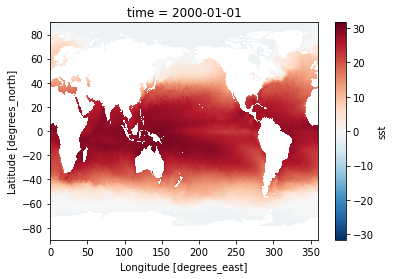

In [5]:
# Resample to monthly
oisst = sst.resample(time="1MS").mean(dim="time")
oisst.isel(time = 0).sst.plot()

# Prep/Combine SODA variables

Soda datasets on box are split into salinity and temperature arrays, and arrays for each of them that contain only the deepest value. We don't really care what the actual depth was, so we can rename the variables to surface and bottom X, and combine into one dataset.

In [6]:
# Drop the depth dimension where it exists, then rebuild.
# Takes the first layer for depth to grab surface measurements in the case of SST and bottom in the case where there


def remove_st_ocean(xr_ds, var):
    """Pull out data as an array, drop st_ocean dimension, rebuild xr.array. 
    Need to pull surface measurement from surface data arrays so depth coordinate
    becomes unnecessary.
    
    Args:
        xr_ds      : xr.ArrayDataset
        var (str)  : String indicating variable to pull and process
    
    """
    
    # Take the data values out as an array
    data = xr_ds[var].values 
    
    # Take all values from each dimension EXCEPT depth
    if var in ["surf_temp", "surf_sal"]:
        data = data[:, 0, :, :] 
    
    # Pull the coordinates
    time     = xr_ds.coords['time']
    xt_ocean = xr_ds.coords['xt_ocean']
    yt_ocean = xr_ds.coords['yt_ocean']

    # Building an xr.array
    xr_manual = xr.DataArray(data, coords = [time, yt_ocean, xt_ocean])
    return xr_manual

### Bottom Temperature

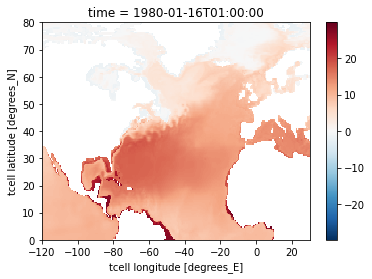

In [7]:
# Load SODA Bottom Temperature
soda_btemp = xr.open_dataset(f"{soda_root}/SODA_Temp_Red_bottomLayer.nc")
soda_btemp = soda_btemp.rename_vars({"temp" : "bot_temp"}).drop("st_ocean")
# # Drop depth, rename variable, reconstruct array
soda_btemp = remove_st_ocean(xr_ds = soda_btemp, var = "bot_temp")
soda_btemp.isel(time = 0).plot()

### Bottom Salinity

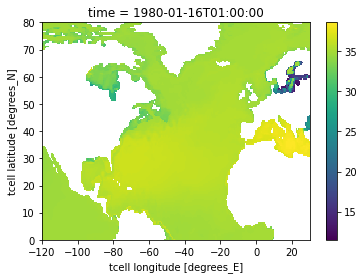

In [8]:
# Load SODA Bottom Salinity
soda_bsalt = xr.open_dataset(f"{soda_root}/SODA_Salt_Red_bottomLayer.nc")
soda_bsalt = soda_bsalt.rename_vars({"salt" : "bot_sal"}).drop("st_ocean")
# # Drop depth, rename variable, reconstruct array
soda_bsalt = remove_st_ocean(xr_ds = soda_bsalt, var = "bot_sal")
soda_bsalt.isel(time = 0).plot()

### Surface Salinity

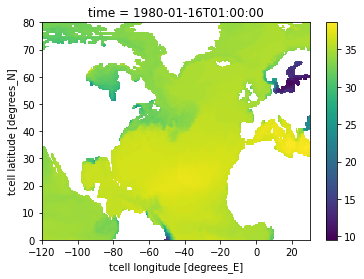

In [9]:
# Load SODA Salinity
soda_salt = xr.open_dataset(f"{soda_root}/SODA_Salt_Red.nc")
soda_salt = soda_salt.rename_vars({"salt" : "surf_sal"}).drop("st_ocean")
# Drop depth, rename variable, reconstruct array
soda_salt = remove_st_ocean(xr_ds = soda_salt, var = "surf_sal")
soda_salt.isel(time = 0).plot()

### Combine the Soda Variables

In [10]:
# Put them all together as one thing
soda_full = xr.Dataset({
    "surf_sal"  : soda_salt,
    "bot_temp"  : soda_btemp,
    "bot_sal"   : soda_bsalt})

# Inspect it
soda_full 

<xarray.Dataset>
Dimensions:   (time: 480, yt_ocean: 160, xt_ocean: 300)
Coordinates:
  * time      (time) datetime64[ns] 1980-01-16T01:00:00 ... 2019-12-12T01:00:00
  * yt_ocean  (yt_ocean) float64 0.25 0.75 1.25 1.75 ... 78.25 78.75 79.25 79.75
  * xt_ocean  (xt_ocean) float64 -119.8 -119.2 -118.8 ... 28.75 29.25 29.75
Data variables:
    surf_sal  (time, yt_ocean, xt_ocean) float32 34.96 34.95 ... 33.67 33.69
    bot_temp  (time, yt_ocean, xt_ocean) float32 9.94 9.944 ... 0.1655 0.2248
    bot_sal   (time, yt_ocean, xt_ocean) float32 34.72 34.72 ... 34.95 34.95

# Next Steps:
 * Process the annual average and seasonal averages for the reference period

In [14]:
# Limit years
oisst_trimmed = oisst.sel(time = slice("2000-01-01", "2019-01-01"))
soda_trimmed = soda_full.sel(time = slice("2000-01-01", "2019-01-01"))

# Get the overall average
oisst_base = oisst_trimmed.mean("time")
soda_base = soda_trimmed.mean("time")

# Limit years and get seasonal average:
oisst_seasonal_base = oisst_trimmed.groupby("time.season").mean("time")
soda_seasonal_base = soda_trimmed.groupby("time.season").mean("time")
soda_seasonal_base

<xarray.Dataset>
Dimensions:   (yt_ocean: 160, xt_ocean: 300, season: 4)
Coordinates:
  * yt_ocean  (yt_ocean) float64 0.25 0.75 1.25 1.75 ... 78.25 78.75 79.25 79.75
  * xt_ocean  (xt_ocean) float64 -119.8 -119.2 -118.8 ... 28.75 29.25 29.75
  * season    (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    surf_sal  (season, yt_ocean, xt_ocean) float32 34.8 34.8 ... 33.36 33.37
    bot_temp  (season, yt_ocean, xt_ocean) float32 9.953 9.953 ... 1.313 1.353
    bot_sal   (season, yt_ocean, xt_ocean) float32 34.72 34.72 ... 34.89 34.9

## Map the spring conditions

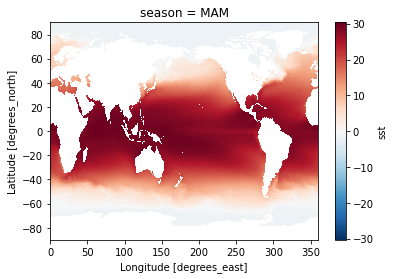

In [15]:
oisst_seasonal_base.sel(season = "MAM").sst.plot()

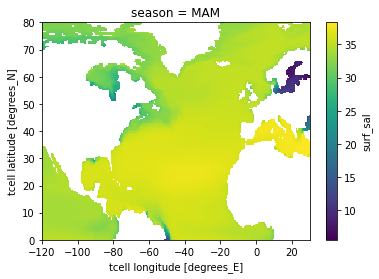

In [25]:
soda_seasonal_base.sel(season = "MAM").surf_sal.plot()

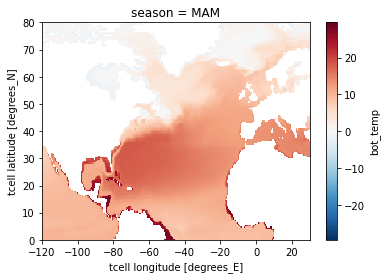

In [26]:
soda_seasonal_base.sel(season = "MAM").bot_temp.plot()

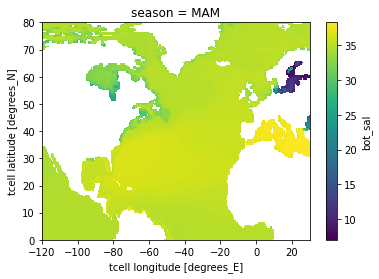

In [27]:
soda_seasonal_base.sel(season = "MAM").bot_sal.plot()

## Export these out

These can now be used to create maps that describe the baseline conditions of the reference data.

In [38]:
# Save them all
save_folder = f"{cmip_root}/Bias_Correction_Checking/Baseline_Env_Grids/"
print(f"Saving files out to: {save_folder}")
print(f"Saved on:  {datetime.date.today()}")
soda_base.to_netcdf(f"{save_folder}SODA_2000to2019_avg.nc")
soda_seasonal_base.to_netcdf(f"{save_folder}SODA_2000to2019_seasonal_avg.nc")
oisst_base.to_netcdf(f"{save_folder}OISST_2000to2019_avg.nc")
oisst_seasonal_base.to_netcdf(f"{save_folder}OISST_2000to2019_seasonal_avg.nc")
print("Done Reference Data")

Saving files out to: /Users/akemberling/Library/CloudStorage/Box-Box/RES_Data/CMIP6/Bias_Correction_Checking/Baseline_Env_Grids/
Saved on:  2023-07-27
Done Reference Data


---

# Ensemble Baselines

For direct comparisons, I will repeat the above steps using the bias-corrected SSP scenario ensemble means. Box isn't cooperating right now...

In [16]:
# SSP1
ssp1_btemp = xr.open_dataset(f"{cmip_root}/SSP1_26/BiasCorrected/EnsembleData/bot_temp/bot_temp_SODA_bias_corrected_mean.nc")
ssp1_stemp = xr.open_dataset(f"{cmip_root}/SSP1_26/BiasCorrected/EnsembleData/surf_temp/surf_temp_OISST_bias_corrected_mean.nc")
#ssp1_stemp = ssp1_stemp.resample(time="1MS").mean(dim="time")

# # And SSP5
ssp5_btemp = xr.open_dataset(f"{cmip_root}/SSP5_85/BiasCorrected/EnsembleData/bot_temp/bot_temp_SODA_bias_corrected_mean.nc")
ssp5_stemp = xr.open_dataset(f"{cmip_root}/SSP5_85/BiasCorrected/EnsembleData/surf_temp/surf_temp_OISST_bias_corrected_mean.nc")
#ssp5_stemp = ssp5_stemp.resample(time="1MS").mean(dim="time")
ssp1_stemp

<xarray.Dataset>
Dimensions:    (longitude: 240, latitude: 200, time: 1812)
Coordinates:
  * longitude  (longitude) float64 260.1 260.4 260.6 260.9 ... 319.4 319.6 319.9
  * latitude   (latitude) float64 69.88 69.62 69.38 69.12 ... 20.62 20.38 20.12
  * time       (time) datetime64[ns] 1950-01-15 1950-02-15 ... 2100-12-15
Data variables:
    sst        (time, latitude, longitude) float32 ...
    crs        int32 ...
Attributes:
    Conventions:  CF-1.4
    created_by:   R packages ncdf4 and terra (version 1.7-29)
    date:         2023-07-31 16:14:50

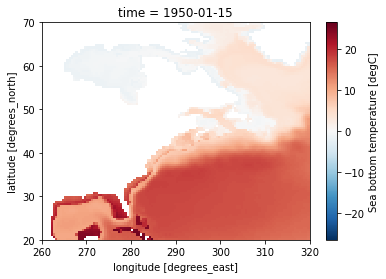

In [19]:
ssp1_btemp.isel(time = 0).bot_temp.plot()

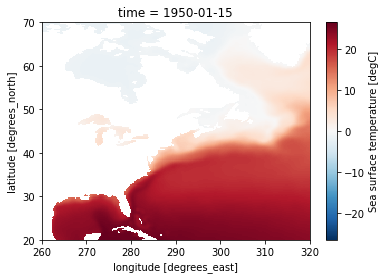

In [20]:
ssp1_stemp.isel(time = 0).sst.plot()

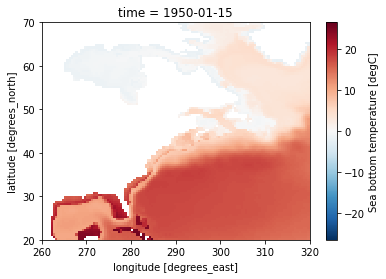

In [21]:
ssp5_btemp.isel(time = 0).bot_temp.plot()

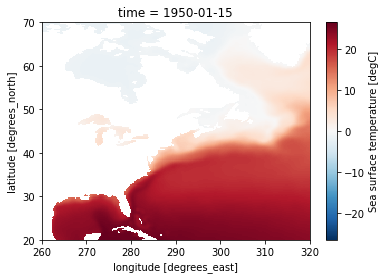

In [22]:
ssp5_stemp.isel(time = 0).sst.plot()

In [24]:
# Put the two variables together
# Put them all together as one thing
ssp1_full = xr.Dataset({
    "surf_temp"  : ssp1_stemp.sst,
    "bot_temp"  : ssp1_btemp.bot_temp})

# Inspect it
ssp1_full 


<xarray.Dataset>
Dimensions:    (latitude: 300, longitude: 360, time: 1812)
Coordinates:
  * latitude   (latitude) float64 20.12 20.25 20.38 20.62 ... 69.62 69.75 69.88
  * longitude  (longitude) float64 260.1 260.2 260.4 260.6 ... 319.6 319.8 319.9
  * time       (time) datetime64[ns] 1950-01-15 1950-02-15 ... 2100-12-15
Data variables:
    surf_temp  (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    bot_temp   (time, latitude, longitude) float32 nan nan nan ... nan nan nan

In [25]:
# Put the two variables together
# Put them all together as one thing
ssp5_full = xr.Dataset({
    "surf_temp"  : ssp5_stemp.sst,
    "bot_temp"  : ssp5_btemp.bot_temp})

# Inspect it
ssp5_full 

<xarray.Dataset>
Dimensions:    (latitude: 300, longitude: 360, time: 1812)
Coordinates:
  * latitude   (latitude) float64 20.12 20.25 20.38 20.62 ... 69.62 69.75 69.88
  * longitude  (longitude) float64 260.1 260.2 260.4 260.6 ... 319.6 319.8 319.9
  * time       (time) datetime64[ns] 1950-01-15 1950-02-15 ... 2100-12-15
Data variables:
    surf_temp  (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    bot_temp   (time, latitude, longitude) float32 nan nan nan ... nan nan nan

In [26]:
# Limit years
ssp1_trimmed = ssp1_full.sel(time = slice("2000-01-01", "2019-01-01"))
ssp5_trimmed = ssp5_full.sel(time = slice("2000-01-01", "2019-01-01"))

# Get the overall average
ssp1_base = ssp1_trimmed.mean("time")
ssp5_base = ssp5_trimmed.mean("time")

# Limit years and get seasonal average:
ssp1_seasonal_base = ssp1_trimmed.groupby("time.season").mean("time")
ssp5_seasonal_base = ssp5_trimmed.groupby("time.season").mean("time")
ssp5_seasonal_base

<xarray.Dataset>
Dimensions:    (latitude: 300, longitude: 360, season: 4)
Coordinates:
  * latitude   (latitude) float64 20.12 20.25 20.38 20.62 ... 69.62 69.75 69.88
  * longitude  (longitude) float64 260.1 260.2 260.4 260.6 ... 319.6 319.8 319.9
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    surf_temp  (season, latitude, longitude) float32 nan nan nan ... nan nan nan
    bot_temp   (season, latitude, longitude) float32 nan nan nan ... nan nan nan

In [46]:
# Save them all
save_folder = f"{cmip_root}/Bias_Correction_Checking/Baseline_Env_Grids/"
print(f"Saving files out to: {save_folder}")
print(f"Saved on:  {datetime.date.today()}")
ssp1_base.to_netcdf(f"{save_folder}SSP1_26_2000to2019_avg.nc")
ssp1_seasonal_base.to_netcdf(f"{save_folder}SSP1_26_2000to2019_seasonal_avg.nc")
ssp5_base.to_netcdf(f"{save_folder}SSP5_85_2000to2019_avg.nc")
ssp5_seasonal_base.to_netcdf(f"{save_folder}SSP5_85_2000to2019_seasonal_avg.nc")
print("Done Saving Bias-Corrected SSP Reference Period Data")

Saving files out to: /Users/akemberling/Library/CloudStorage/Box-Box/RES_Data/CMIP6/Bias_Correction_Checking/Baseline_Env_Grids/
Saved on:  2023-08-01
Done Saving Bias-Corrected SSP Reference Period Data


<xarray.Dataset>
Dimensions:    (latitude: 300, longitude: 360)
Coordinates:
  * latitude   (latitude) float64 20.12 20.25 20.38 20.62 ... 69.62 69.75 69.88
  * longitude  (longitude) float64 260.1 260.2 260.4 260.6 ... 319.6 319.8 319.9
Data variables:
    surf_temp  (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan
    bot_temp   (latitude, longitude) float32 nan nan nan nan ... nan nan nan nan